In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam
from keras.utils import to_categorical
import os

Using TensorFlow backend.


In [2]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [3]:
Ty_train = to_categorical(y_train)
Ty_test = to_categorical(y_test)

In [4]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
original_generator = ImageDataGenerator()
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [2]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

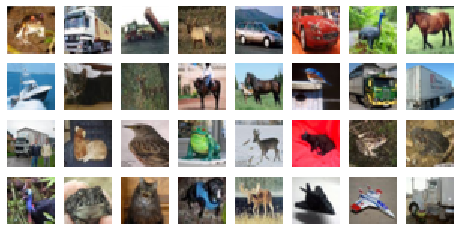

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

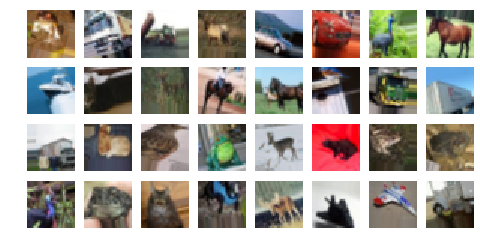

In [7]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

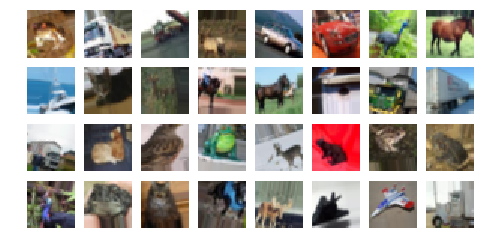

In [9]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [5]:
batch_size = 128 # batch 的大小，如果出現 OOM error，請降低這個值
num_classes = 10 # 類別的數量，Cifar 10 共有 10 個類別
epochs = 20 # 訓練的 epochs 數量

In [6]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
cnn.add(Activation('relu'))
cnn.add(Conv2D(32, (3, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64, (3, 3), padding='same'))
cnn.add(Activation('relu'))
cnn.add(Conv2D(64, (3, 3)))
cnn.add(Activation('relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(512))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(num_classes))
cnn.add(Activation('softmax'))
cnn.summary()

cnn.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
______________________

In [7]:
CNN = []
test_generator = original_generator.flow(x_test, Ty_test, shuffle=False)

for generator in (original_generator, data_generator):
    train_generator = generator.flow(x_train, Ty_train, shuffle=True)
    cnn.fit_generator(
        train_generator,
        steps_per_epoch=x_train.shape[0]//batch_size,
        epochs=epochs,
        verbose=1)
    CNN.append(
        cnn.evaluate_generator(test_generator, steps=x_test.shape[0]//batch_size, verbose=0)
    )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





390/390 [==============================] - 9s 23ms/step - loss: 1.9224 - acc: 0.2974
Epoch 2/20
390/390 [==============================] - 5s 12ms/step - loss: 1.5402 - acc: 0.4462
Epoch 3/20
390/390 [==============================] - 5s 12ms/step - loss: 1.3903 - acc: 0.5087
Epoch 4/20
390/390 [==============================] - 5s 12ms/step - loss: 1.2938 - acc: 0.5403: 0s - loss: 1.31
Epoch 5/20
390/390 [==============================] - 5s 13ms/step - loss: 1.1942 - acc: 0.5841
Epoch 6/20
390/390 [==============================] - 5s 12ms/step - loss: 1.1486 - acc: 0.5943
Epoch 7/20
390/390 [==============================] - 5s 12ms/step - loss: 1.1081 - acc: 0.6158
Epoch 8/20
390/390 [==============================] - 5s 12ms/step - loss: 1.0998 - acc: 0.6166
Epoch 9/20
390/390 [==============================] - 5s 12ms/step - loss: 1.0249 - acc: 0.6438
Epoch 10/20
390/3

In [8]:
CNN

[[0.9344647404475089, 0.6806891025641025],
 [1.2979762569451943, 0.5552884615384616]]